#### This notebook contains the code for 4 parts.

1. Exploratory Data Analysis 
2. Example of SARIMAX Model
3. Example of Facebook Prophet Model
4. Example of XGBoost model 

In [2]:
# loading packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

import datetime
%matplotlib inline

import warnings

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pyflux as pf
from sklearn.metrics import mean_squared_error

In [273]:
# Set fonts for plots
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Part 1: Exploratory data analysis 

### 0). Load Data

In [4]:
train = pd.read_csv("data/train.csv", 
                    low_memory = False,
                    dtype={'Store': np.int64,
                           'DayOfWeek': 'category',
                           'Sales':np.int64,
                           'Customers':np.int64,
                           'Open':np.int8,
                           'Promo':np.int8,
                           'StateHoliday':'category',
                           'SchoolHoliday':np.int8},
                   index_col='Date')

In [5]:
store = pd.read_csv("data/store.csv",
                   dtype={'Store':np.int64,
                          'StoreType':'category',
                          'Assortment':'category',
                          'Promo2':np.int8,
                         })

### 1). Exploration on Sales Data

In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [9]:
train.info()
#there are 1,017,209 records in total

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null category
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int8
Promo            1017209 non-null int8
StateHoliday     1017209 non-null category
SchoolHoliday    1017209 non-null int8
dtypes: category(2), int64(3), int8(3)
memory usage: 35.9+ MB


In [10]:
#covert type of 'Date' from int to datetime
train.reset_index(inplace=True)
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index('Date')

In [11]:
train.sort_index(inplace = True)

In [12]:
#get dummies for stateholiday
train = pd.get_dummies(train, columns=['StateHoliday'], drop_first = True)

In [13]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,1,1,0,0
2013-01-01,379,2,0,0,0,0,1,1,0,0
2013-01-01,378,2,0,0,0,0,1,1,0,0
2013-01-01,377,2,0,0,0,0,1,1,0,0
2013-01-01,376,2,0,0,0,0,1,1,0,0


In [14]:
print('There are {:,} stores.'.format(train.Store.nunique()))

There are 1,115 stores.


In [15]:
#date range
print('The records are between {} and {}.'.format(train.index.min(), train.index.max()))
print('There are {:,} days in total.'.format(train.index.nunique()))

The records are between 2013-01-01 00:00:00 and 2015-07-31 00:00:00.
There are 942 days in total.


In [16]:
#count missing values
print('There are {} missing values.'.format(train.isnull().any().sum()))

There are 0 missing values.


In [17]:
#Sale record count for stores
sale_record_number = pd.DataFrame(train.groupby('Store')['Sales'].count())
sale_record_number.rename(columns = {'Sales': 'sale_record_number'}, inplace = True)

In [18]:
sale_record_number_count = pd.DataFrame(sale_record_number['sale_record_number'].value_counts()).reset_index()
sale_record_number_count.columns = ['record_count','num_of_stores']

In [19]:
sale_record_number_count

,record_count,num_of_stores
0,942,934
1,758,180
2,941,1


In [20]:
for index, row in sale_record_number_count.iterrows():
    print('{0} stores have {1} sale records out of 942 days.'.format(row.num_of_stores, row.record_count)) if (row.num_of_stores > 1) else print('{0} store has {1} sale records out of 942 days.'.format(row.num_of_stores, row.record_count))

934 stores have 942 sale records out of 942 days.
180 stores have 758 sale records out of 942 days.
1 store has 941 sale records out of 942 days.


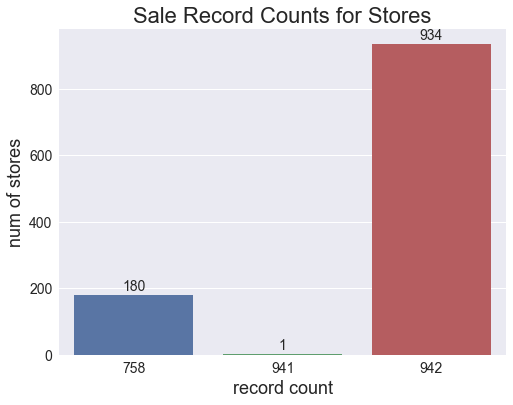

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.barplot(x = 'record_count', y = 'num_of_stores', data = sale_record_number_count, ax = ax)
ax.set_title('Sale Record Counts for Stores')
ax.set_xlabel('record count')
ax.set_ylabel('num of stores')
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 15,
            '{:,.0f}'.format(p.get_height()),
            ha="center") 

In [22]:
print('Stores with 758 records are {}.'.format(list(sale_record_number[sale_record_number.sale_record_number == 758].index)))

Stores with 758 records are [13, 20, 22, 32, 36, 41, 46, 51, 52, 58, 72, 76, 81, 89, 99, 100, 108, 113, 115, 127, 129, 132, 136, 137, 139, 144, 145, 149, 155, 159, 164, 165, 172, 174, 181, 183, 186, 190, 191, 192, 204, 215, 218, 231, 243, 258, 263, 275, 277, 279, 283, 284, 287, 288, 298, 306, 317, 342, 345, 348, 365, 385, 399, 407, 412, 413, 420, 427, 428, 429, 430, 434, 457, 471, 477, 485, 490, 492, 498, 500, 501, 512, 514, 518, 522, 534, 539, 540, 542, 547, 555, 571, 573, 575, 587, 598, 604, 611, 612, 619, 620, 629, 633, 636, 637, 638, 644, 646, 650, 660, 669, 670, 671, 677, 684, 694, 701, 702, 706, 710, 711, 712, 716, 719, 736, 739, 744, 750, 766, 771, 775, 778, 797, 804, 805, 806, 815, 820, 825, 842, 851, 858, 859, 879, 884, 890, 893, 900, 902, 903, 904, 909, 915, 919, 920, 932, 941, 952, 974, 977, 989, 1000, 1004, 1009, 1012, 1019, 1027, 1038, 1041, 1049, 1056, 1065, 1067, 1080, 1092, 1094, 1102, 1104, 1107, 1109].


In [23]:
train.Open.value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [24]:
#count open records
print('There are {:,} open records.'.format(train.Open.astype(bool).sum()))
print('There are {:,} non-open records.'.format(len(train)-train.Open.astype(bool).sum()))

There are 844,392 open records.
There are 172,817 non-open records.


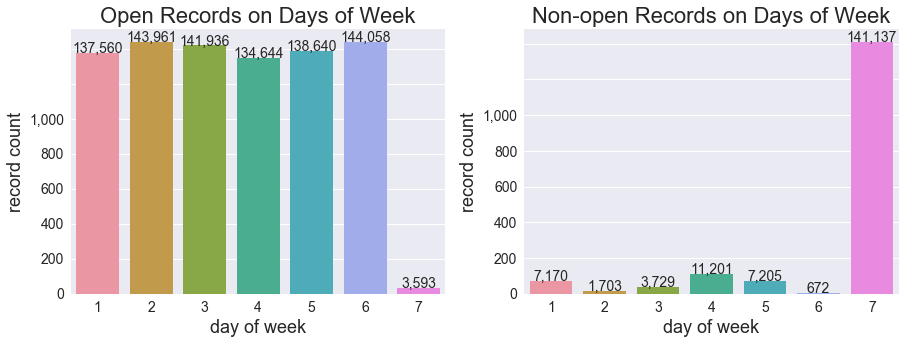

In [25]:
#open and non-open records distribution on days of week
open_records = pd.DataFrame(train.loc[train.Open==1].DayOfWeek.value_counts()).sort_index().reset_index().rename(columns = {'index': 'day_of_week', 'DayOfWeek': 'record_count'})

non_open_records = pd.DataFrame(train.loc[train.Open==0].DayOfWeek.value_counts()).sort_index().reset_index().rename(columns = {'index': 'day_of_week', 'DayOfWeek': 'record_count'})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
sns.barplot(x = 'day_of_week', y = 'record_count', data = open_records, ax = ax1)
ax1.set_title('Open Records on Days of Week')
ax1.set_xlabel('day of week')
ax1.set_ylabel('record count')

sns.barplot(x = 'day_of_week', y = 'record_count', data = non_open_records, ax = ax2)
ax2.set_title('Non-open Records on Days of Week')
ax2.set_xlabel('day of week')
ax2.set_ylabel('record count')

ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]);

for p in ax1.patches:
    ax1.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 20,
            '{:,.0f}'.format(p.get_height()),
            ha="center") 
for p in ax2.patches:
    ax2.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 20,
            '{:,.0f}'.format(p.get_height()),
            ha="center")
plt.tight_layout()

In [26]:
#count non zeros in sales
print('There are {:,} non-zero sales.'.format(train.Sales.astype(bool).sum()))
print('There are {:,} zero sales.'.format(len(train)-train.Sales.astype(bool).sum()))

There are 844,338 non-zero sales.
There are 172,871 zero sales.


In [27]:
#Stores that open on Sundays.
print('There are {} stores open on Sundays.'.format(train[(train.DayOfWeek == '7') & (train.Sales != 0)]['Store'].nunique()))
print('They are {}.'.format(list(train[(train.DayOfWeek == '7') & (train.Sales != 0)]['Store'].unique())))

There are 33 stores open on Sundays.
They are [353, 310, 335, 494, 530, 423, 85, 274, 262, 259, 948, 863, 1097, 682, 676, 578, 562, 769, 733, 512, 1045, 877, 1099, 122, 209, 299, 524, 453, 732, 931, 867, 433, 1081].


### 2) Exploration on Competition Stores Data

In [28]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


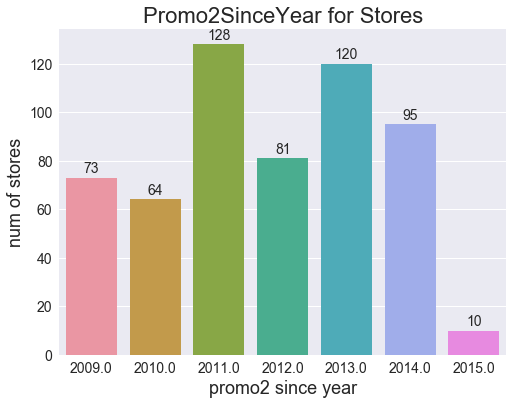

In [44]:
# Count stores for different promo2sinceyear
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.barplot(x = 'index', y = 'Promo2SinceYear', data = pd.DataFrame(store.Promo2SinceYear.value_counts()).sort_index().reset_index(), ax = ax)
ax.set_title('Promo2SinceYear for Stores')
ax.set_xlabel('promo2 since year')
ax.set_ylabel('num of stores')
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 2,
            '{:,.0f}'.format(p.get_height()),
            ha="center") 

In [45]:
#promo2 interval types
store.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [46]:
num_competitors = pd.DataFrame(pd.DataFrame(store.groupby(['Store'])['CompetitionDistance'].count())['CompetitionDistance'].value_counts()).reset_index()
num_competitors.columns = ['num_competitor', 'store_count']

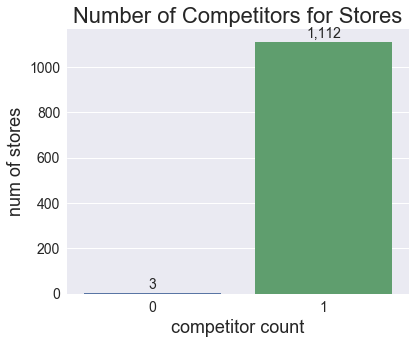

In [47]:
# for index, row in num_competitors.iterrows():
#     print('{0} stores have {1} competitor.'.format(row.store_count, row.num_competitor))

fig, ax = plt.subplots(1, 1, figsize=(6,5))
sns.barplot(x = 'num_competitor', y = 'store_count', data = num_competitors, ax = ax)
ax.set_title('Number of Competitors for Stores')
ax.set_xlabel('competitor count')
ax.set_ylabel('num of stores');
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 20,
            '{:,.0f}'.format(p.get_height()),
            ha="center") 
plt.tight_layout();

In [48]:
competitor_open_date = pd.DataFrame(columns = ['open_date_info', 'store_count'])
competitor_open_date = competitor_open_date.append(pd.DataFrame([['missing', store[(store.CompetitionOpenSinceYear.isnull()) & ((store.CompetitionDistance > 0))].Store.nunique()]], columns = ['open_date_info', 'store_count']))
competitor_open_date = competitor_open_date.append(pd.DataFrame([['before 2013', store[store.CompetitionOpenSinceYear < 2013].Store.nunique()]], columns = ['open_date_info', 'store_count']))
competitor_open_date = competitor_open_date.append(pd.DataFrame([['after 2013', store[store.CompetitionOpenSinceYear >= 2013].Store.nunique()]], columns = ['open_date_info', 'store_count']))

Among the 1,112 stores with competitors:
 351 stores have missing competitor.
 570 stores have before 2013 competitor.
 191 stores have after 2013 competitor.


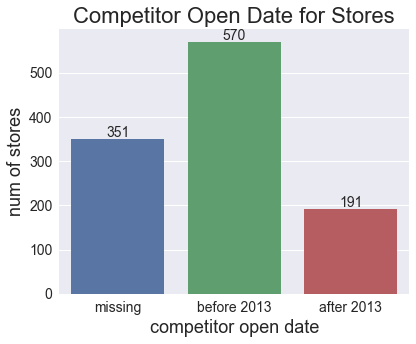

In [49]:
print("Among the {:,} stores with competitors:".format(num_competitors[num_competitors.num_competitor == 1].store_count[0]))
for index, row in competitor_open_date.iterrows():
    print(' {0} stores have {1} competitor.'.format(row.store_count, row.open_date_info))

fig, ax = plt.subplots(1, 1, figsize=(6,5))
sns.barplot(x = 'open_date_info', y = 'store_count', data = competitor_open_date, ax = ax)
ax.set_title('Competitor Open Date for Stores')
ax.set_xlabel('competitor open date')
ax.set_ylabel('num of stores')
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2.,
            p.get_height() + 5,
            '{:,.0f}'.format(p.get_height()),
            ha="center");
plt.tight_layout()

In [50]:
print('The stores with competitor opend after 2013 are {}.'
      .format(list(store[(store.CompetitionOpenSinceYear >= 2013)]['Store'].unique())))

The stores with competitor opend after 2013 are [5, 6, 7, 8, 14, 28, 30, 33, 37, 45, 47, 51, 52, 53, 54, 57, 75, 84, 95, 103, 106, 110, 116, 120, 122, 126, 131, 133, 137, 138, 159, 166, 169, 170, 181, 185, 189, 191, 197, 213, 214, 219, 221, 225, 230, 246, 249, 261, 262, 263, 264, 266, 268, 269, 270, 275, 276, 280, 286, 301, 304, 315, 317, 318, 321, 326, 336, 347, 355, 361, 369, 375, 380, 386, 391, 395, 403, 413, 416, 423, 428, 432, 447, 449, 452, 461, 488, 489, 490, 496, 506, 513, 518, 523, 524, 525, 539, 550, 551, 555, 556, 560, 563, 578, 581, 585, 595, 598, 599, 601, 604, 608, 626, 629, 630, 635, 646, 647, 653, 661, 675, 677, 683, 685, 688, 706, 715, 718, 730, 740, 745, 752, 770, 774, 784, 788, 800, 801, 810, 814, 819, 828, 837, 839, 859, 872, 878, 882, 901, 902, 903, 904, 905, 915, 918, 929, 944, 947, 952, 954, 956, 958, 963, 967, 970, 983, 986, 993, 995, 996, 1003, 1013, 1019, 1020, 1032, 1034, 1038, 1040, 1041, 1044, 1045, 1050, 1053, 1059, 1072, 1075, 1085, 1086, 1094, 1099, 1111

### 3) Visualization of Sales for 4 Different Type of Stores

In [51]:
def plot_sales(store_num):
    plt.figure(1,figsize=(20,5)) 
    plt.plot_date(train[train.Store==store_num].index,train.loc[train.Store==store_num,'Sales'],linestyle='-')
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title("Sales over Time for Store {:,}".format(store_num));

#### Type 1: Closed on Sundays (Store 1)

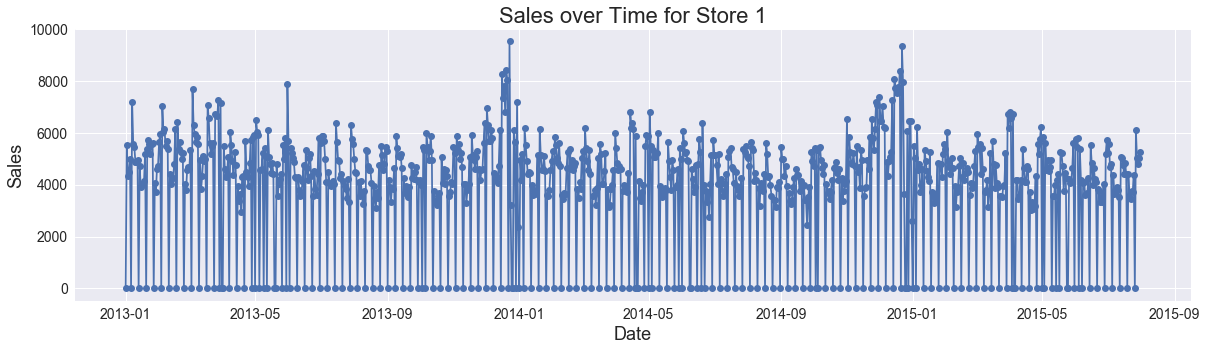

In [52]:
plot_sales(1)

#### Type 2: Opened on Sundays (Store 85)

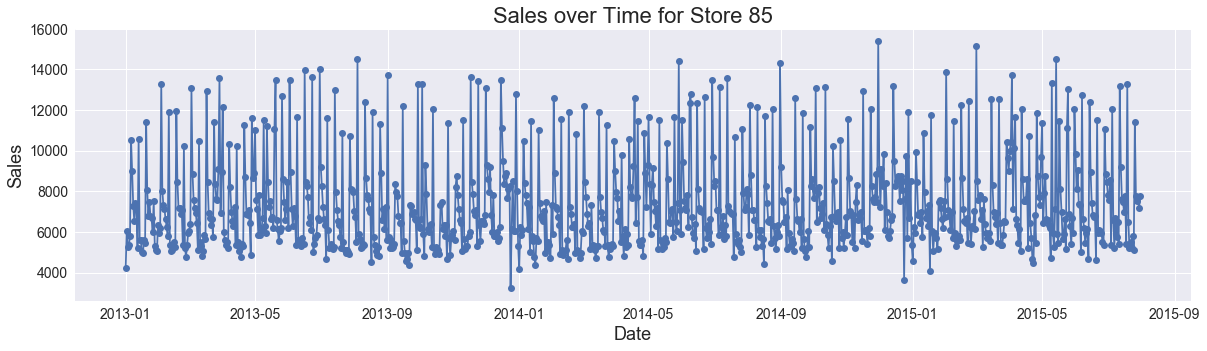

In [53]:
plot_sales(85)

#### Type 3: Competitor Opened After 2013 (Store 30)

In [54]:
store[store.CompetitionOpenSinceYear>=2013].sort_values('CompetitionDistance').head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
881,882,a,a,30.0,4.0,2013.0,0,NaN,NaN,NaN
982,983,a,a,40.0,3.0,2014.0,1,1.0,2014.0,"Jan,Apr,Jul,Oct"
29,30,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1019,1020,a,a,40.0,8.0,2015.0,0,NaN,NaN,NaN
522,523,c,c,50.0,11.0,2013.0,0,NaN,NaN,NaN


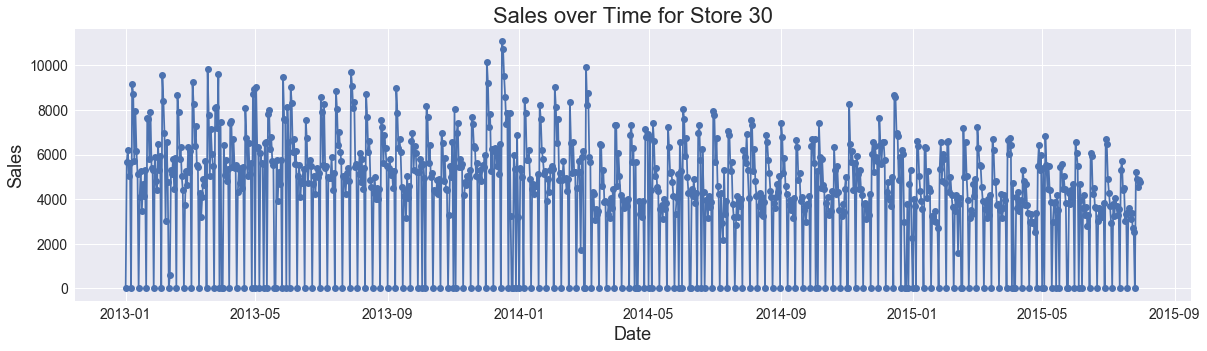

In [55]:
plot_sales(30)

#### 4). Type 4: Missing Sale Records for Half an Year (Store 13)

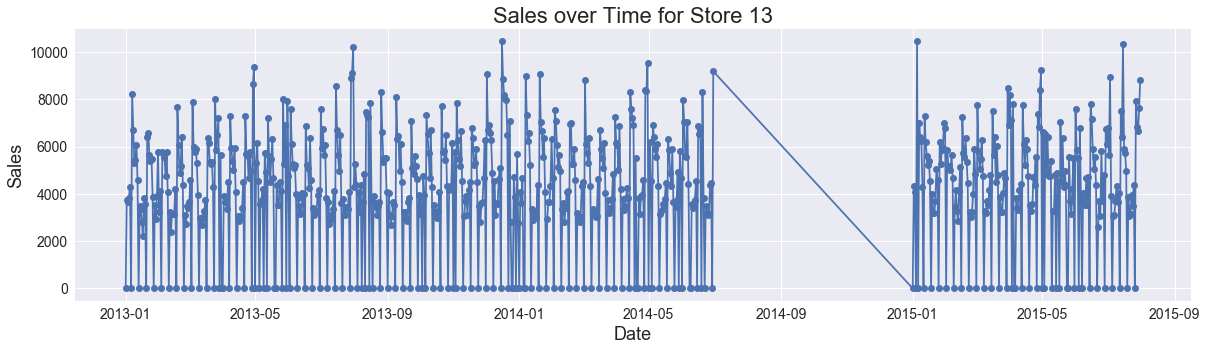

In [56]:
plot_sales(13)

### 4) Add Features (year, month, week, promo2 and competitor info)

In [57]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c
Date,,,,,,,,,,
2013-01-01,1115,2,0,0,0,0,1,1,0,0
2013-01-01,379,2,0,0,0,0,1,1,0,0
2013-01-01,378,2,0,0,0,0,1,1,0,0
2013-01-01,377,2,0,0,0,0,1,1,0,0
2013-01-01,376,2,0,0,0,0,1,1,0,0


In [58]:
train['year'] = train.index.year
train['month'] = train.index.month
train['week'] = train.index.week
train['day'] = train.index.day

In [213]:
#create master_df only with stores having full records
master_df = train.join(sale_record_number, how='left', on='Store')
master_df = master_df[master_df.sale_record_number == 942]
del master_df['sale_record_number']
master_df.reset_index(inplace = True)

In [60]:
master_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,year,month,week,day
0,2013-01-01,1115,2,0,0,0,0,1,1,0,0,2013,1,1,1
1,2013-01-01,379,2,0,0,0,0,1,1,0,0,2013,1,1,1
2,2013-01-01,378,2,0,0,0,0,1,1,0,0,2013,1,1,1
3,2013-01-01,377,2,0,0,0,0,1,1,0,0,2013,1,1,1
4,2013-01-01,376,2,0,0,0,0,1,1,0,0,2013,1,1,1


In [214]:
master_df = pd.merge(master_df, store, on='Store', how='left')

In [215]:
master_df = master_df.sort_values(['Date', 'Store']).reset_index(drop = True)

In [63]:
master_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,...,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,1,2,0,0,0,0,1,1,0,...,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2013-01-01,2,2,0,0,0,0,1,1,0,...,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,2013-01-01,3,2,0,0,0,0,1,1,0,...,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,2013-01-01,4,2,0,0,0,0,1,1,0,...,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,2013-01-01,5,2,0,0,0,0,1,1,0,...,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [216]:
master_df['promo2_open'] = 365 * (master_df.year - master_df.Promo2SinceYear) + 7 * (master_df.week - master_df.Promo2SinceWeek)
master_df['promo2_open'] = master_df.promo2_open.apply(lambda x: 1 if x >= 0 else 0)

In [217]:
# There are three promointerval types: 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov' and 'Mar,Jun,Sept,Dec'
# replace the promointerval string with promointerval promoitnerval type number
master_df['PromoInterval'] = master_df.PromoInterval.map({'Jan,Apr,Jul,Oct': 1, 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec':3})

In [218]:
# promo2_stage = (month - PromoInterval)%3 + 1
# for example: month = Jan, PromoInterval = 1, promo2_stage = (1 - 1)%3 + 1 = 1, promo2 is in the first stage
# month = Feb, PromoInterval = 2, promo2_stage = (2 - 1)%3 + 1 = 2, promo2 is in the second stage
# and so on. 
master_df['promo2_stage'] = (master_df.month - master_df.PromoInterval)%3 + 1

In [219]:
master_df['competitor_open'] = 12 * (master_df.year - master_df.CompetitionOpenSinceYear) + (master_df.month - master_df.CompetitionOpenSinceMonth)
master_df['competitor_open'] = master_df.competitor_open.apply(lambda x: 0 if x < 0 else 1)

In [220]:
master_df.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,promo2_open,promo2_stage,competitor_open
0,2013-01-01,1,2,0,0,0,0,1,1,0,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,0,NaN,1
1,2013-01-01,2,2,0,0,0,0,1,1,0,...,570.0,11.0,2007.0,1,13.0,2010.0,1.0,1,1.0,1
2,2013-01-01,3,2,0,0,0,0,1,1,0,...,14130.0,12.0,2006.0,1,14.0,2011.0,1.0,1,1.0,1
3,2013-01-01,4,2,0,0,0,0,1,1,0,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,0,NaN,1
4,2013-01-01,5,2,0,0,0,0,1,1,0,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,0,NaN,0


In [69]:
master_df.CompetitionDistance.max()

75860.0

In [221]:
#Fill nan values for Competition Distance with 10 times the max value
master_df.CompetitionDistance.fillna(758600, inplace=True)

In [222]:
#Fill nan values for promo2_stage with 0 and convert promo2_stage to dummy variables
master_df.promo2_stage.fillna(0, inplace = True)
master_df = pd.get_dummies(master_df, columns=['promo2_stage'], drop_first=True)

In [72]:
master_df.Store.nunique()

934

## Part 2: SARIMAX model with Box Jenkins methods for Store 1

In [73]:
# helper function to plot residuals
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    plt.figure(figsize=(20,15)) 
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

### Step 1. Determine the differencing order

In [131]:
store_1_data = train.loc[(train.Store==1) & (train.DayOfWeek != '7')]

In [75]:
store_1_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,year,month,week,day
Date,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,1,1,0,0,2013,1,1,1
2013-01-02,1,3,5530,668,1,0,1,0,0,0,2013,1,1,2
2013-01-03,1,4,4327,578,1,0,1,0,0,0,2013,1,1,3
2013-01-04,1,5,4486,619,1,0,1,0,0,0,2013,1,1,4
2013-01-05,1,6,4997,635,1,0,1,0,0,0,2013,1,1,5


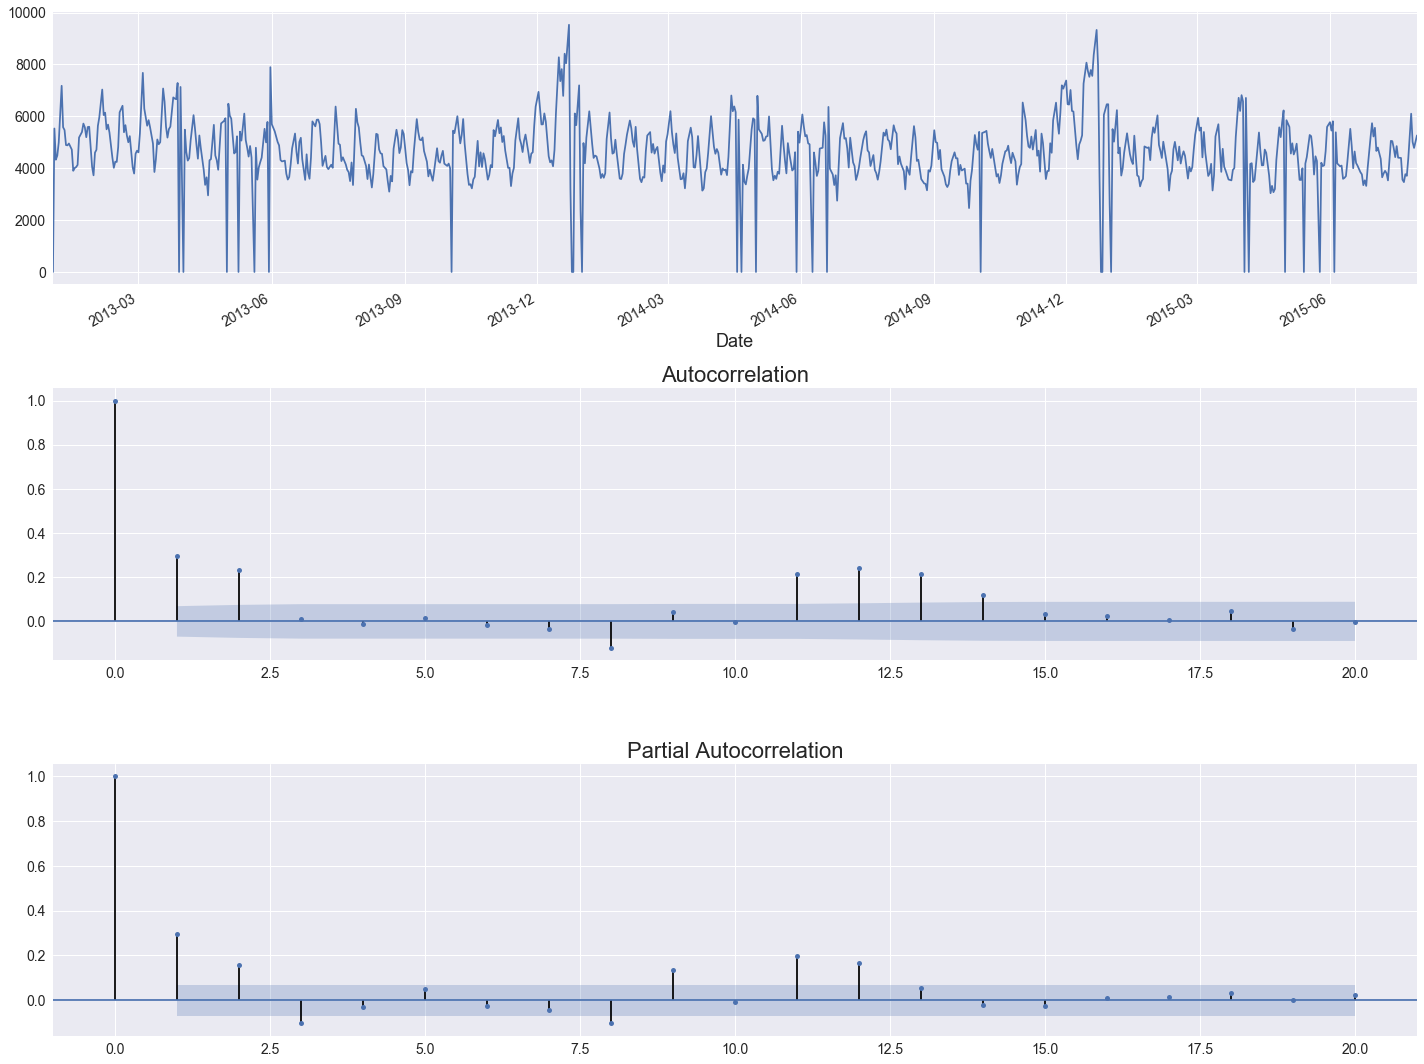

In [76]:
plots(store_1_data['Sales'], lags=20)

The autocorrelation with lags decays quickly, indicating no differencing is needed. 

### Step 2. Try AR(1) model with exogenous featues

In [77]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#AR(1) model with exogeous features
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(1,0,0), seasonal_order=(0,0,0,0), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  808
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -6438.785
Date:                Tue, 26 Sep 2017   AIC                          12895.570
Time:                        09:08:36   BIC                          12937.822
Sample:                    01-01-2013   HQIC                         12911.794
                         - 07-31-2015                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          6.0319     46.801      0.129      0.897     -85.697      97.760
Open            4562.2577     87.632     52.062      0.000    4390.503    4734.013
Promo            556.3563     64.672      8.603      0.000     429.602     683.111
SchoolHoliday    -43.3906     97.381     -0.446      0.656    -234.253     147.472
StateHoliday_a  -502.3886    122.245     -4.110      0.000    -741.985    -262.792
StateHoliday_b  -615.0791    150.936     -4.075      0.000    -910.908    -319.251
StateHoliday_c   -33.7573    228.013     -0.148      0.882    -480.654     413.140
ar.L1              0.6299      0.020     31.335      0.000       0.590       0.669
sigma2          5.063e+05   1.68e+04     30.125      0.000    4.73e+05    5.39e+05
===================================================================================
Ljung-Box (Q):                      328.44   Jarque-Bera (JB):               731.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                             0.07
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.49e+17. Standard errors may be unstable.
"""

In [78]:
Sales_pre = sar.predict()

In [79]:
mean_squared_error(store_1_data.Sales, Sales_pre)

488313.23254212964

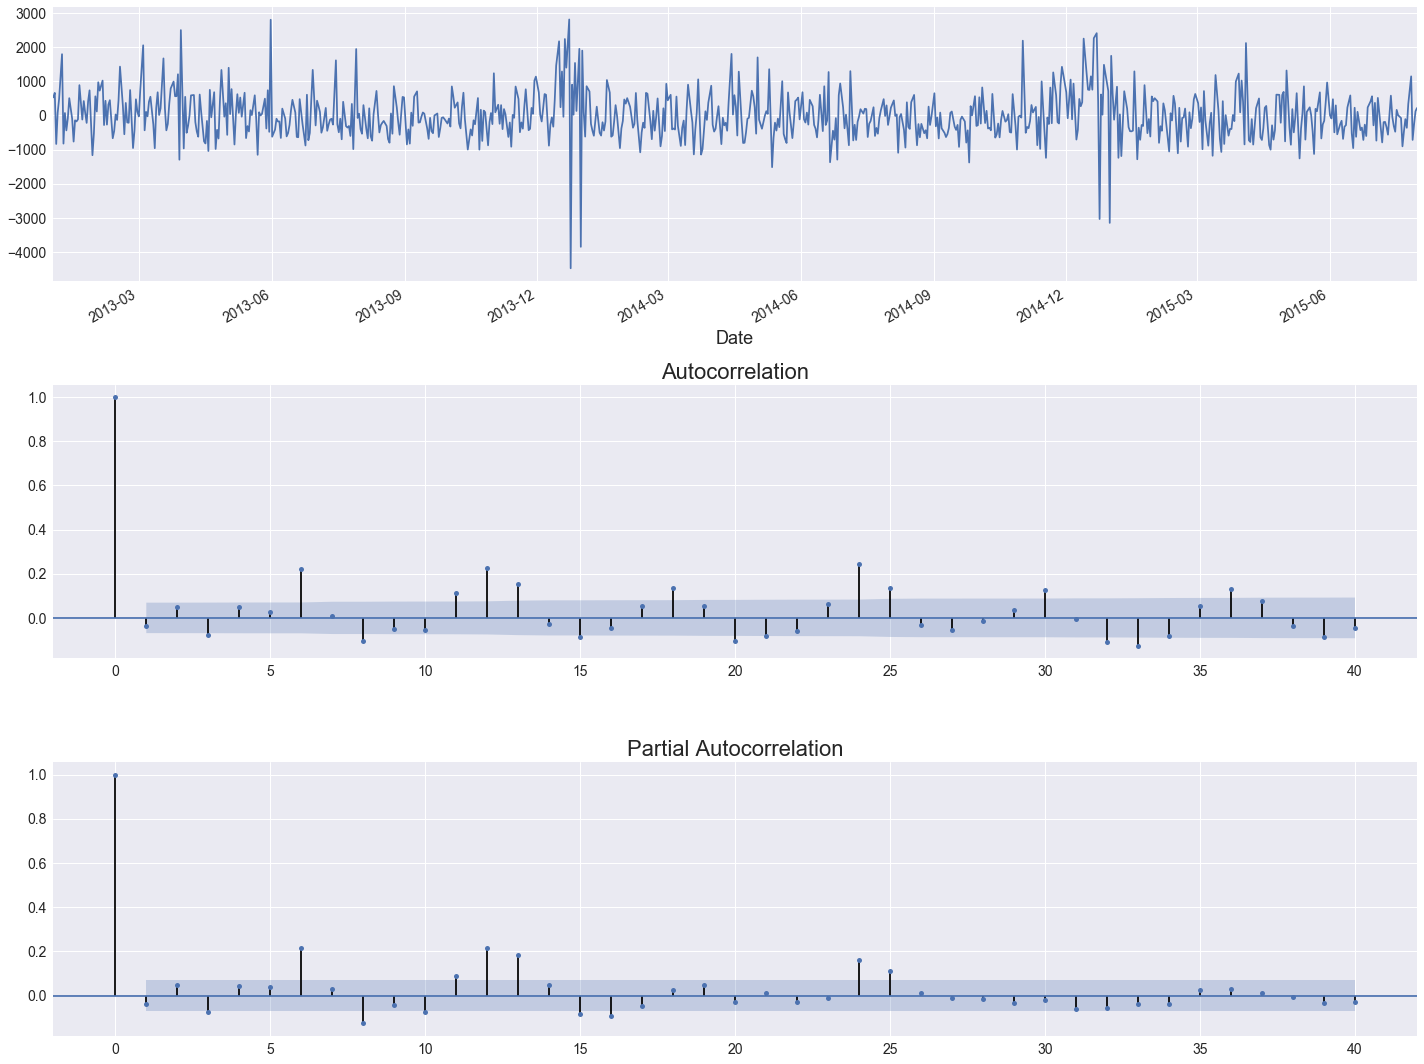

In [80]:
plots(sar.resid, lags=40)

Weekly seasonality is significance. We should add seasonal features.

### Step 3. Tune seasonal parameters

In [81]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#AR(1) model with exogeous features and seasonal features
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(1,0,0), seasonal_order=(4,1,1,6), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(1, 0, 0)x(4, 1, 1, 6)   Log Likelihood               -6310.020
Date:                           Tue, 26 Sep 2017   AIC                          12648.040
Time:                                   09:09:32   BIC                          12713.764
Sample:                               01-01-2013   HQIC                         12673.276
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.7846      0.705     -1.113      0.266      -2.166       0.596
Open            3764.9178   1532.811      2.456      0.014     760.664    6769.171
Promo           1238.8445     67.471     18.361      0.000    1106.604    1371.085
SchoolHoliday     54.6517     83.066      0.658      0.511    -108.155     217.459
StateHoliday_a  -620.7322   1537.371     -0.404      0.686   -3633.924    2392.459
StateHoliday_b -1348.2883   1535.414     -0.878      0.380   -4357.644    1661.067
StateHoliday_c -1795.9475   1541.640     -1.165      0.244   -4817.506    1225.611
ar.L1              0.5291      0.021     25.062      0.000       0.488       0.570
ar.S.L6            0.2206      0.028      8.000      0.000       0.167       0.275
ar.S.L12           0.0111      0.035      0.316      0.752      -0.058       0.080
ar.S.L18           0.0245      0.040      0.620      0.536      -0.053       0.102
ar.S.L24           0.1076      0.038      2.864      0.004       0.034       0.181
ma.S.L6           -0.9906      0.029    -34.351      0.000      -1.047      -0.934
sigma2          3.923e+05   1.65e+04     23.753      0.000     3.6e+05    4.25e+05
===================================================================================
Ljung-Box (Q):                      119.29   Jarque-Bera (JB):               436.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.20
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
Sales_pre = sar.predict()

In [83]:
mean_squared_error(store_1_data.Sales, Sales_pre)

405216.62308896077

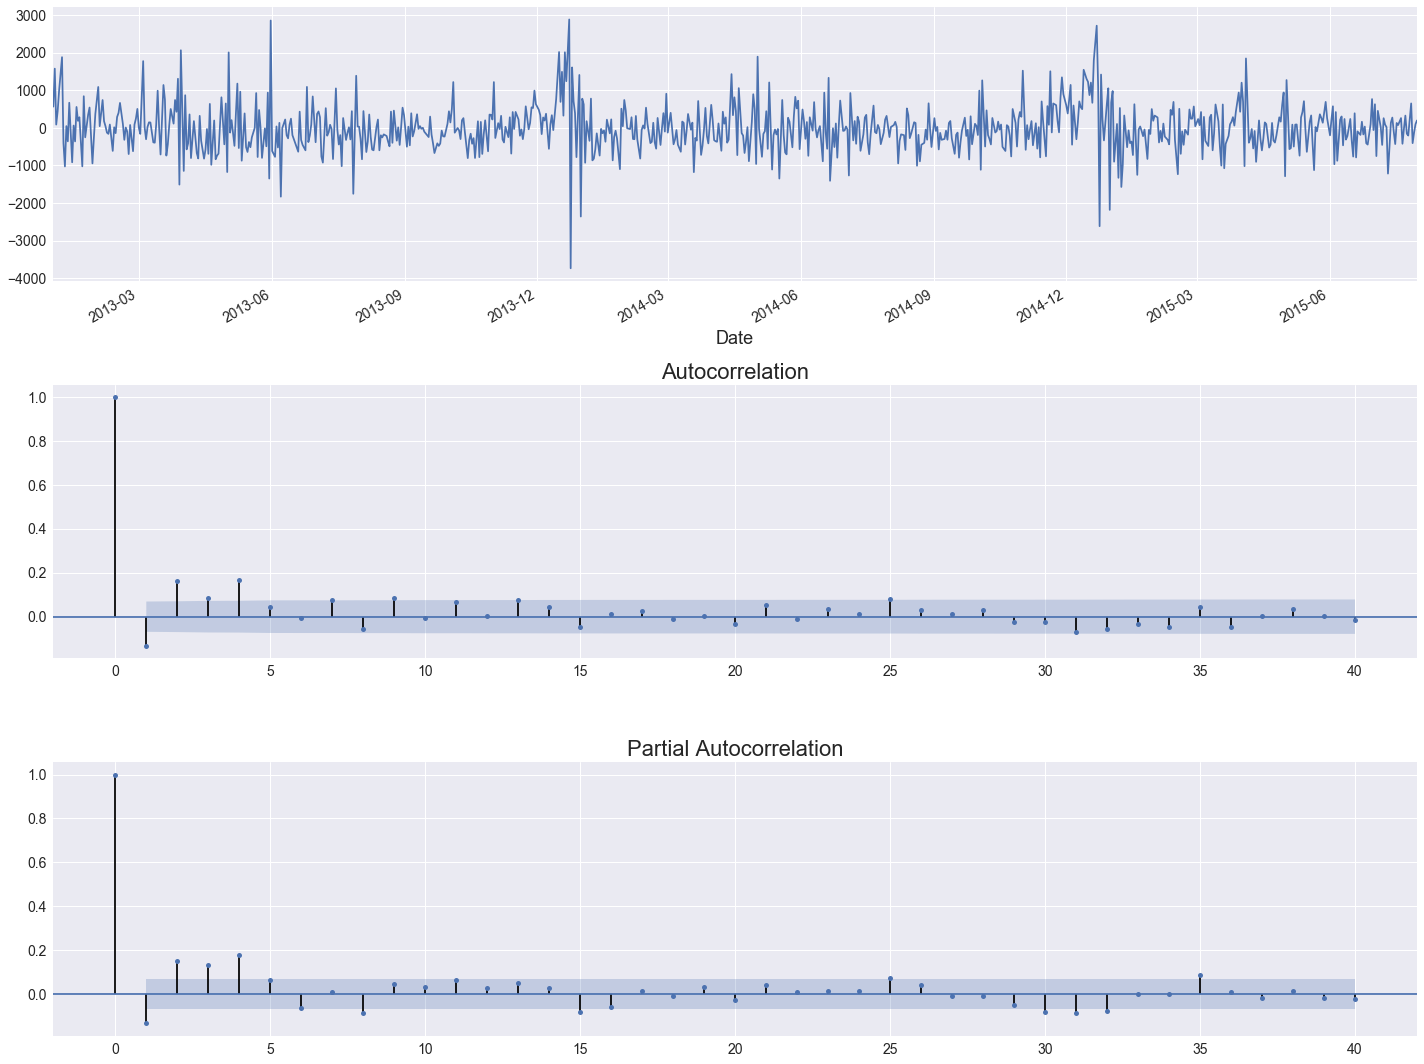

In [84]:
plots(sar.resid, lags=40)

### Step 4. Tune AR and MA lags

In [85]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
#Tune lags for AR model and MA model
sar = sm.tsa.statespace.SARIMAX(store_1_data.Sales, order=(4,0,0), seasonal_order=(4,1,1,6), trend='c', exog=store_1_data[['Open','Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']]).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                             Sales   No. Observations:                  808
Model:             SARIMAX(4, 0, 0)x(4, 1, 1, 6)   Log Likelihood               -6269.867
Date:                           Tue, 26 Sep 2017   AIC                          12573.734
Time:                                   09:10:01   BIC                          12653.542
Sample:                               01-01-2013   HQIC                         12604.378
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.5396      0.612     -0.882      0.378      -1.739       0.660
Open            3760.7316   1770.968      2.124      0.034     289.699    7231.764
Promo           1237.7778     57.300     21.602      0.000    1125.471    1350.084
SchoolHoliday     54.2049     86.115      0.629      0.529    -114.577     222.987
StateHoliday_a  -616.4539   1774.665     -0.347      0.728   -4094.733    2861.826
StateHoliday_b -1346.4058   1764.266     -0.763      0.445   -4804.303    2111.492
StateHoliday_c -1797.7789   1835.571     -0.979      0.327   -5395.433    1799.875
ar.L1              0.3435      0.034      9.961      0.000       0.276       0.411
ar.L2              0.2187      0.032      6.803      0.000       0.156       0.282
ar.L3              0.0871      0.040      2.175      0.030       0.009       0.166
ar.L4              0.0912      0.040      2.271      0.023       0.012       0.170
ar.S.L6            0.1254      0.024      5.259      0.000       0.079       0.172
ar.S.L12           0.0431      0.038      1.124      0.261      -0.032       0.118
ar.S.L18           0.0053      0.042      0.125      0.901      -0.078       0.088
ar.S.L24           0.1305      0.040      3.249      0.001       0.052       0.209
ma.S.L6           -1.0000      0.035    -28.178      0.000      -1.070      -0.930
sigma2          3.502e+05      0.031   1.12e+07      0.000     3.5e+05     3.5e+05
===================================================================================
Ljung-Box (Q):                       55.00   Jarque-Bera (JB):               729.62
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.23
Prob(H) (two-sided):                  0.08   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  1e+26. Standard errors may be unstable.
"""

In [132]:
Sales_pre = sar.predict()

In [139]:
Sales_pre = pd.DataFrame(Sales_pre, columns = ['sales_pre']).reset_index()

In [87]:
mean_squared_error(store_1_data.Sales, Sales_pre)

367658.24349085684

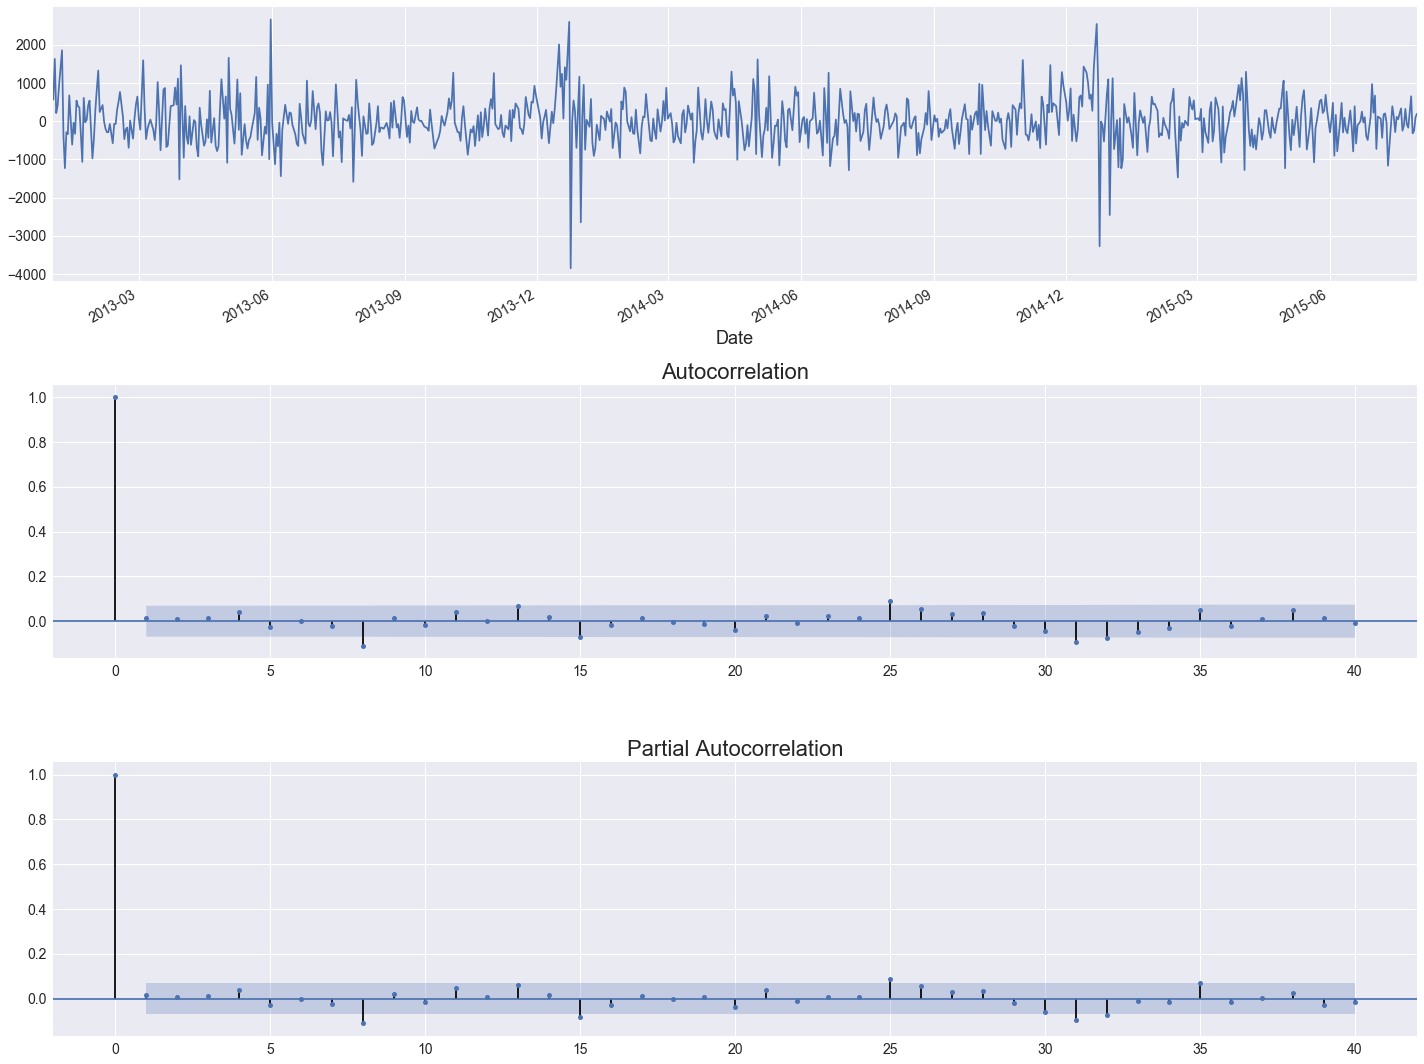

In [88]:
plots(sar.resid, lags=40)

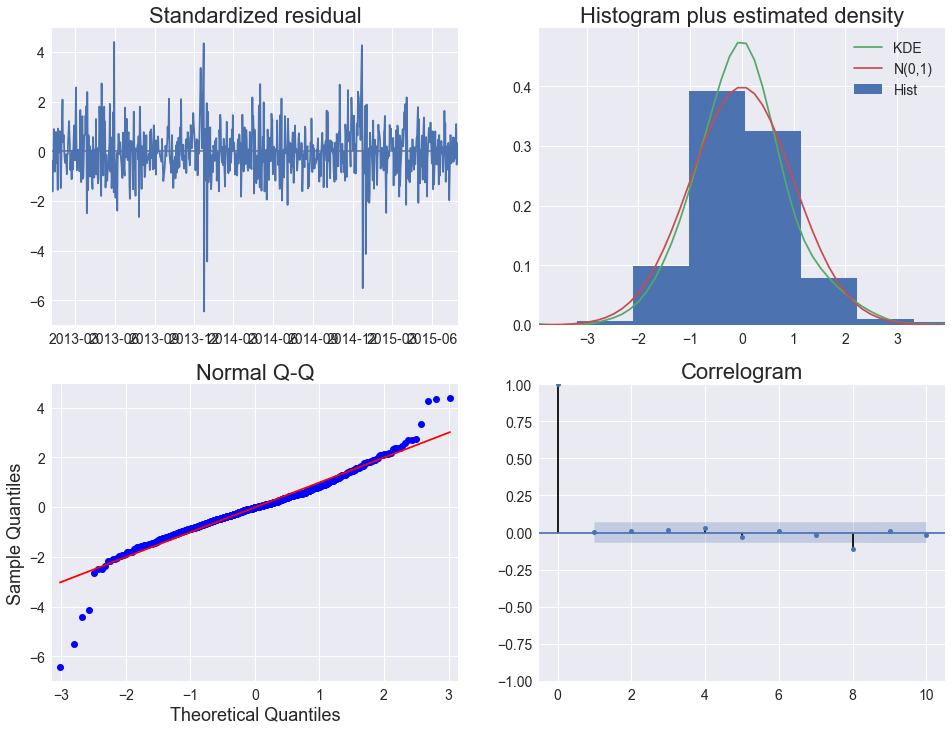

In [89]:
sar.plot_diagnostics(figsize=(16,12));

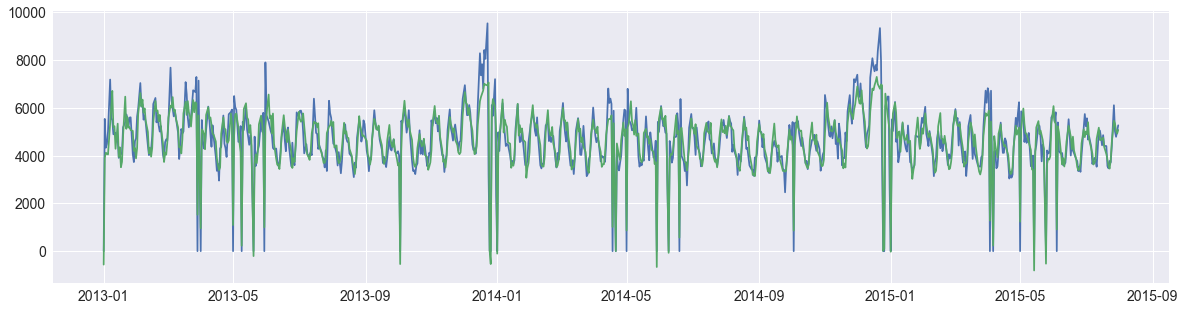

In [90]:
plt.figure(figsize=(20,5)) 
plt.plot_date(store_1_data.index, store_1_data.Sales, fmt='-')
plt.plot_date(store_1_data.index, Sales_pre, fmt='-');

## Part 3: Facebook Prophet Model for Store 1

In [103]:
from fbprophet import Prophet

In [104]:
store_1_data_fb = master_df[master_df.Store==1]

In [105]:
store_1_data_fb.reset_index(inplace = True)

In [106]:
# facebook prophet model requires that, the column name for date is 'ds', and the column name for predicted value is 'y'.
store_1_data_fb.rename(columns = {'Sales': 'y', 'Date': 'ds'}, inplace = True)

In [107]:
dropdate = datetime.datetime.strptime('2013-01-07', "%Y-%m-%d")
traindate = datetime.datetime.strptime('2015-06-30', "%Y-%m-%d")

In [108]:
train_store_1_fb = store_1_data_fb[store_1_data_fb.ds <= traindate]

In [111]:
# create holidays dataframe for facebook prophet model
def make_holidays(df):
    closed = pd.DataFrame({
      'holiday': 'closed',
      'ds': pd.to_datetime(df[df.Open == 0].ds),
      'lower_window': 0, # these help us specify spillover into previous and future days
      'upper_window': 1,
    })

    promos = pd.DataFrame({
      'holiday': 'promo',
      'ds': pd.to_datetime(df[df.Promo == 1].ds),
      'lower_window': 0, # these help us specify spillover into previous and future days
      'upper_window': 1,
    })

    school_holidays = pd.DataFrame({
      'holiday': 'school_holiday',
      'ds': pd.to_datetime(df[df.SchoolHoliday == 1].ds),
      'lower_window': 0,
      'upper_window': 1,
    })
    
    state_holiday_a = pd.DataFrame({
      'holiday': 'school_holiday',
      'ds': pd.to_datetime(df[df.StateHoliday_a == 1].ds),
      'lower_window': 0,
      'upper_window': 1,
    })


    state_holiday_b = pd.DataFrame({
      'holiday': 'school_holiday',
      'ds': pd.to_datetime(df[df.StateHoliday_b == 1].ds),
      'lower_window': 0,
      'upper_window': 1,
    })

    state_holiday_c = pd.DataFrame({
      'holiday': 'school_holiday',
      'ds': pd.to_datetime(df[df.StateHoliday_c == 1].ds),
      'lower_window': 0,
      'upper_window': 1,
    })
    

    holidays = pd.concat((closed, promos, school_holidays, state_holiday_a, state_holiday_b, state_holiday_c))

    return holidays

In [112]:
holidays = make_holidays(store_1_data_fb)

In [118]:
m = Prophet(holidays=holidays, daily_seasonality=False)
m.fit(train_store_1_fb);

In [119]:
forecast = m.predict(store_1_data_fb)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,198.153846,-541.234285,919.573470
1,2013-01-02,5794.217280,5070.980411,6606.605711
2,2013-01-03,4486.921072,3785.833570,5211.499064
3,2013-01-04,4592.605406,3892.385947,5323.784576
4,2013-01-05,5508.747296,4783.047836,6212.562017


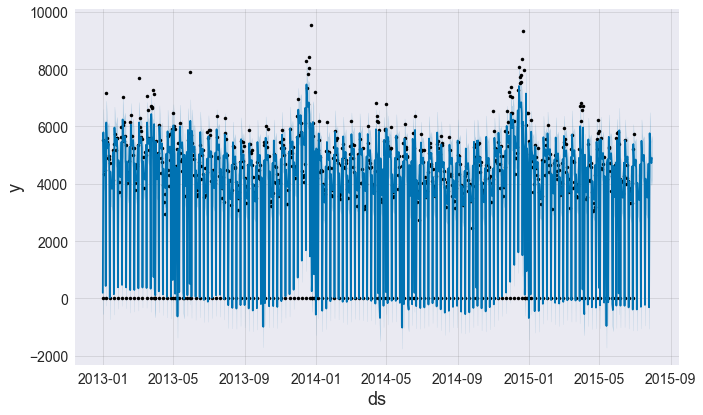

In [120]:
m.plot(forecast);

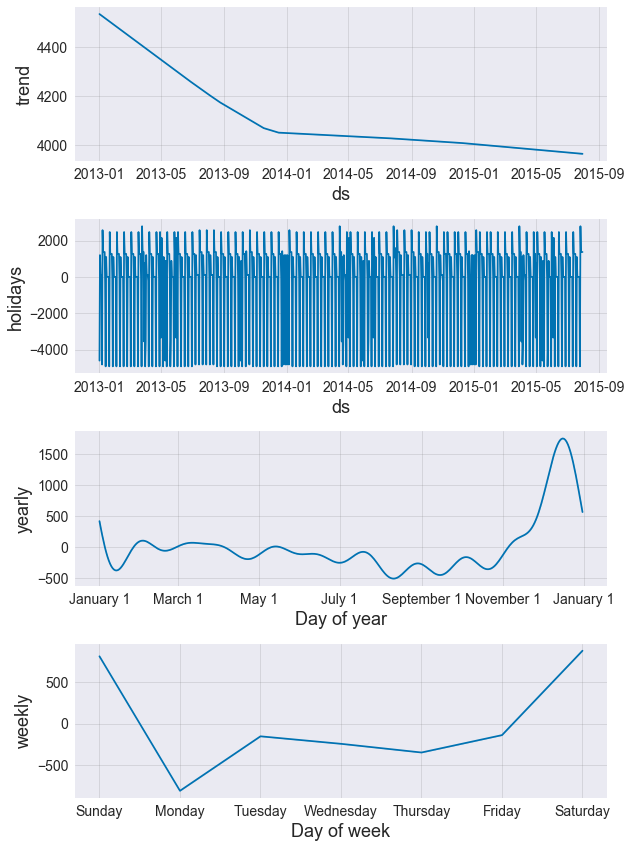

In [148]:
# Facebook Prophet model breaks down the complicated time series pattern into four components: trand, holidays, and yearly and weekly seasonalities. 
m.plot_components(forecast);

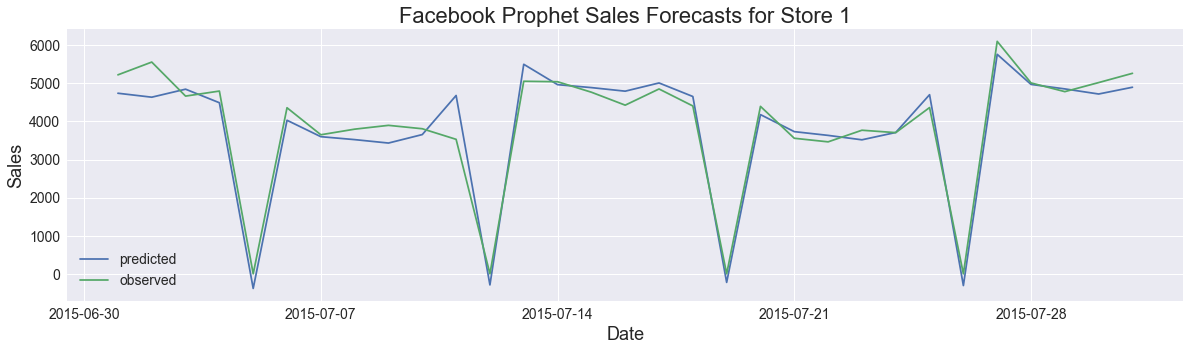

In [147]:
# Plot predicted sales vs observed sales
plt.figure(figsize=(20,5))
plt.plot_date(forecast[forecast.ds > traindate].ds, forecast[forecast.ds > traindate].yhat, fmt='-', label = 'predicted');
plt.plot_date(store_1_data_fb[store_1_data_fb.ds > traindate].ds, store_1_data_fb[store_1_data_fb.ds > traindate].y, fmt='-', label = 'observed')
plt.title('Facebook Prophet Sales Forecasts for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend();

In [127]:
print('Mean_squared_error of Prophet is: {:,.0f}.'.format(mean_squared_error(store_1_data_fb[store_1_data_fb.ds > traindate].y, forecast[forecast.ds > traindate].yhat)))

Mean_squared_error of Prophet is: 142,193.


In [153]:
print('Mean_squared_error of SARIMAX is: {:,.0f}.'.format(mean_squared_error(store_1_data[store_1_data.index > traindate].Sales, Sales_pre[Sales_pre.Date > traindate].sales_pre)))

Mean_squared_error of SARIMAX is: 144,767.


In [142]:
from sklearn.metrics import r2_score

In [151]:
print('R2 of Prophet is: {:,.4f}.'.format(r2_score(store_1_data_fb[store_1_data_fb.ds > traindate].y, forecast[forecast.ds > traindate].yhat)))

R2 of Prophet is: 0.9467.


In [154]:
print('R2 of SARIMAX is: {:,.4f}.'.format(r2_score(store_1_data[store_1_data.index > traindate].Sales, Sales_pre[Sales_pre.Date > traindate].sales_pre)))

R2 of SARIMAX is: 0.6873.


## Part 4: XGBoosting model

In [224]:
master_df.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'year', 'month', 'week', 'day', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'promo2_open', 'competitor_open',
       'promo2_stage_1.0', 'promo2_stage_2.0', 'promo2_stage_3.0'],
      dtype='object')

In [225]:
master_df.rename(columns = {'promo2_stage_1.0': 'promo2_stage_1', 'promo2_stage_2.0': 'promo2_stage_2', 'promo2_stage_3.0': 'promo2_stage_3'}, inplace=True)

In [226]:
# Dropped columns of 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'promo2_open', and 'week'.")
master_df.drop(['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'promo2_open', 'week'], axis=1, inplace=True)

In [227]:
# Converted month, year, dayofweek, storetype and assortment to dummy variables.
master_df = pd.get_dummies(master_df, columns=['month', 'year', 'DayOfWeek', 'StoreType', 'Assortment'], drop_first=True)

In [228]:
master_df = master_df.sort_values(['Date', 'Store']).reset_index(drop = True)

In [229]:
master_df.head()

,Date,Store,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c
0,2013-01-01,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2013-01-01,2,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,3,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,4,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2013-01-01,5,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
master_df.Store.nunique()

934

In [231]:
master_df.columns

Index(['Date', 'Store', 'Sales', 'Customers', 'Open', 'Promo', 'SchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'day',
       'CompetitionDistance', 'competitor_open', 'promo2_stage_1',
       'promo2_stage_2', 'promo2_stage_3', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'year_2014', 'year_2015', 'DayOfWeek_2',
       'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6',
       'DayOfWeek_7', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

In [232]:
dropdate = datetime.datetime.strptime('2013-01-07', "%Y-%m-%d")
traindate = datetime.datetime.strptime('2015-06-30', "%Y-%m-%d")

In [233]:
#create a column of new_sales. For training data (before 2015 July), the new_sales are exactly the sales; for test data(sales in 2015 July), the new_sales are unknown(filled with NaN values).

master_df['new_sales'] = master_df.apply(lambda row: row.Sales if ((row.year_2015 == 0 ) or (row.month_7 == 0)) else np.nan,axis=1)

In [234]:
#create new columns of previous sales
master_df['sale_1_day_before'] = master_df.groupby(['Store'])['new_sales'].shift(1)
master_df['sale_2_day_before'] = master_df.groupby(['Store'])['new_sales'].shift(2)
master_df['sale_3_day_before'] = master_df.groupby(['Store'])['new_sales'].shift(3)
master_df['sale_4_day_before'] = master_df.groupby(['Store'])['new_sales'].shift(4)
master_df['sale_7_day_before'] = master_df.groupby(['Store'])['new_sales'].shift(7)

In [235]:
master_df = master_df[master_df.Date > dropdate]

In [236]:
#competitor distance are set to a big value when the competitor was not opened yet.
master_df['CompetitionDistance'] = master_df.apply(lambda row: row['CompetitionDistance'] if row['competitor_open'] == 1 else 758600, axis=1)

In [237]:
feature_columns = ['Open', 'Promo', 'SchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'CompetitionDistance', 'promo2_stage_1',
       'promo2_stage_2', 'promo2_stage_3', 'year_2014', 'year_2015',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_b', 'Assortment_c', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'sale_1_day_before',
       'sale_2_day_before', 'sale_3_day_before', 'sale_4_day_before', 'sale_7_day_before']

In [238]:
X = master_df[(master_df.Date <= traindate)][feature_columns]
y = master_df[(master_df.Date <= traindate)]['Sales']

In [239]:
from xgboost.sklearn import XGBRegressor

In [240]:
%run performance_evaluation

In [241]:
xgb_model = XGBRegressor(n_estimators=80, max_depth=10, learning_rate=0.1, subsample=0.9, random_state=91717, feval=rmspe_xg)

In [242]:
X.columns

Index(['Open', 'Promo', 'SchoolHoliday', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'CompetitionDistance', 'promo2_stage_1',
       'promo2_stage_2', 'promo2_stage_3', 'year_2014', 'year_2015',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_b', 'Assortment_c', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'sale_1_day_before',
       'sale_2_day_before', 'sale_3_day_before', 'sale_4_day_before',
       'sale_7_day_before'],
      dtype='object')

In [243]:
#train xgb_model using training data
xgb_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, feval=<function rmspe_xg at 0x11310ec80>,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=80, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=91717,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [244]:
r2_score(xgb_model.predict(X), y)

0.95651202817602543

In [245]:
#predict sales for July, 2015
#use predicted sales as the input for later days in July
date = traindate
for day in range(31):
    date += datetime.timedelta(days=1)
    print('day', day+1, date, end=", ")
    indices = master_df[master_df.Date == date].index
    #print(indices)
    for i, df_index in enumerate(indices):
        master_df.set_value(df_index, 'sale_1_day_before', master_df.loc[df_index-934*1].new_sales)
        master_df.set_value(df_index, 'sale_2_day_before', master_df.loc[df_index-934*2].new_sales)
        master_df.set_value(df_index, 'sale_3_day_before', master_df.loc[df_index-934*3].new_sales)
        master_df.set_value(df_index, 'sale_4_day_before', master_df.loc[df_index-934*4].new_sales)
        master_df.set_value(df_index, 'sale_7_day_before', master_df.loc[df_index-934*7].new_sales)
    
    predicted_values = xgb_model.predict(master_df.loc[indices][feature_columns])
    #print(predicted_values)
    
    for i, df_index in enumerate(indices):
        master_df.set_value(df_index, 'new_sales', predicted_values[i])

day 1 2015-07-01 00:00:00, day 2 2015-07-02 00:00:00, day 3 2015-07-03 00:00:00, day 4 2015-07-04 00:00:00, day 5 2015-07-05 00:00:00, day 6 2015-07-06 00:00:00, day 7 2015-07-07 00:00:00, day 8 2015-07-08 00:00:00, day 9 2015-07-09 00:00:00, day 10 2015-07-10 00:00:00, day 11 2015-07-11 00:00:00, day 12 2015-07-12 00:00:00, day 13 2015-07-13 00:00:00, day 14 2015-07-14 00:00:00, day 15 2015-07-15 00:00:00, day 16 2015-07-16 00:00:00, day 17 2015-07-17 00:00:00, day 18 2015-07-18 00:00:00, day 19 2015-07-19 00:00:00, day 20 2015-07-20 00:00:00, day 21 2015-07-21 00:00:00, day 22 2015-07-22 00:00:00, day 23 2015-07-23 00:00:00, day 24 2015-07-24 00:00:00, day 25 2015-07-25 00:00:00, day 26 2015-07-26 00:00:00, day 27 2015-07-27 00:00:00, day 28 2015-07-28 00:00:00, day 29 2015-07-29 00:00:00, day 30 2015-07-30 00:00:00, day 31 2015-07-31 00:00:00, 

In [246]:
master_df[(master_df.Store ==1) & (master_df.Date >= traindate)].head()

,Date,Store,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,...,StoreType_c,StoreType_d,Assortment_b,Assortment_c,new_sales,sale_1_day_before,sale_2_day_before,sale_3_day_before,sale_4_day_before,sale_7_day_before
849940,2015-06-30,1,5735,568,1,1,0,0,0,0,...,1,0,0,0,5735.000000,5197.000000,0.000000,4019.000000,3317.0,3762.0
850874,2015-07-01,1,5223,562,1,1,0,0,0,0,...,1,0,0,0,5094.474121,5735.000000,5197.000000,0.000000,4019.0,3346.0
851808,2015-07-02,1,5558,573,1,1,0,0,0,0,...,1,0,0,0,4809.670898,5094.474121,5735.000000,5197.000000,0.0,3533.0
852742,2015-07-03,1,4665,538,1,1,0,0,0,0,...,1,0,0,0,4743.846680,4809.670898,5094.474121,5735.000000,5197.0,3317.0
853676,2015-07-04,1,4797,560,1,0,0,0,0,0,...,1,0,0,0,3889.526611,4743.846680,4809.670898,5094.474121,5735.0,4019.0


In [247]:
master_df['new_sales'] = master_df.apply(lambda row: row.new_sales if row.Open == 1 else 0, axis = 1)

In [248]:
xgb_prediction_exp = master_df[(master_df.Store == 1) & (master_df.Date > traindate)]

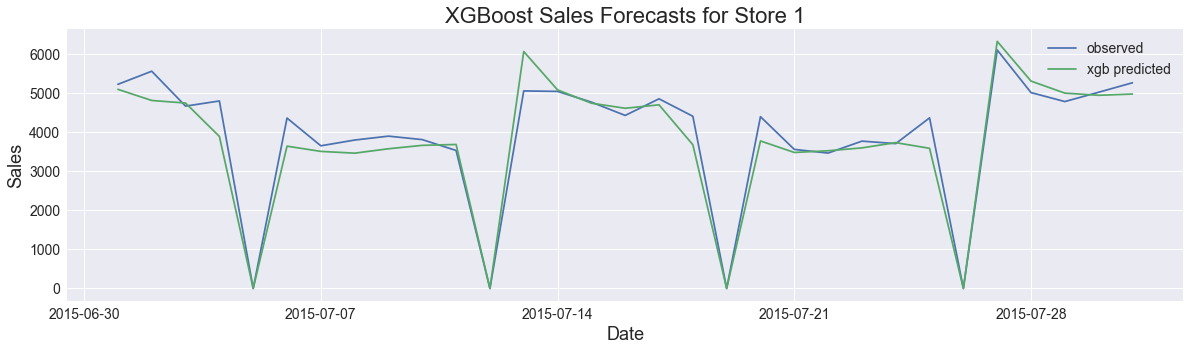

In [274]:
#plot sales forecasts results for store 1 using XGBoost
plt.figure(figsize=(20,5)) 
plt.plot_date(xgb_prediction_exp.Date, xgb_prediction_exp.Sales, fmt='-', label = 'observed')
plt.plot_date(xgb_prediction_exp.Date, xgb_prediction_exp.new_sales, fmt='-', label = 'xgb predicted')
plt.title('XGBoost Sales Forecasts for Store 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend();

In [251]:
#R2 for the forecasts in July for all stores 
r2_score(master_df[(master_df.Date > traindate)].Sales, master_df[(master_df.Date > traindate)].new_sales)

0.86109329107773591

In [252]:
#RMSPE(root mean square percentage error) for the forecasts in July for all stores 
rmspe(master_df[(master_df.Date > traindate)].new_sales, master_df[(master_df.Date > traindate)].Sales)

0.21871723547989225

In [253]:
#RMSPE(root mean square percentage error) for the forecasts in July for Store 1
rmspe(xgb_prediction_exp.new_sales, xgb_prediction_exp.Sales, )

0.087290126196625892

In [255]:
#prepare feature importance dataframe for xgboost
feature_importance = pd.DataFrame(columns = ['feature', 'importance'])
for index, importance in enumerate(xgb_model.feature_importances_):
    feature_importance.loc[index] = [X.columns[index], importance]
feature_importance.sort_values('importance', inplace = True, ascending = False)
feature_importance.reset_index(drop = True, inplace = True)

In [262]:
feature_importance.head()

,feature,importance
0,sale_7_day_before,0.134607
1,sale_1_day_before,0.128676
2,CompetitionDistance,0.101833
3,sale_4_day_before,0.099525
4,sale_2_day_before,0.090408


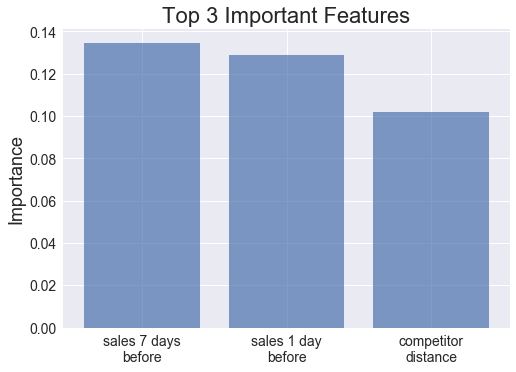

In [275]:
#plot important features in XGBoost model
matplotlib.rcParams.update({'font.size': 16})
objects = ['sales 7 days\nbefore', 'sales 1 day\nbefore', 'competitor\ndistance']
x_pos = np.arange(len(objects))
performance = feature_importance.importance[:3]
 
plt.bar(x_pos, performance, align='center', alpha=0.7)
plt.xticks(x_pos, objects)
plt.ylabel('Importance')
plt.title('Top 3 Important Features')
 
plt.show()

In [269]:
important_columns = ['Sales', 'Open', 'Promo', 'SchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'CompetitionDistance', 'promo2_stage_1',
       'promo2_stage_2', 'promo2_stage_3', 'year_2014', 'year_2015',
       'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5',
       'DayOfWeek_6', 'DayOfWeek_7', 'StoreType_b', 'StoreType_c',
       'StoreType_d', 'Assortment_b', 'Assortment_c', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'sale_1_day_before',
       'sale_2_day_before', 'sale_3_day_before', 'sale_4_day_before', 'sale_7_day_before']

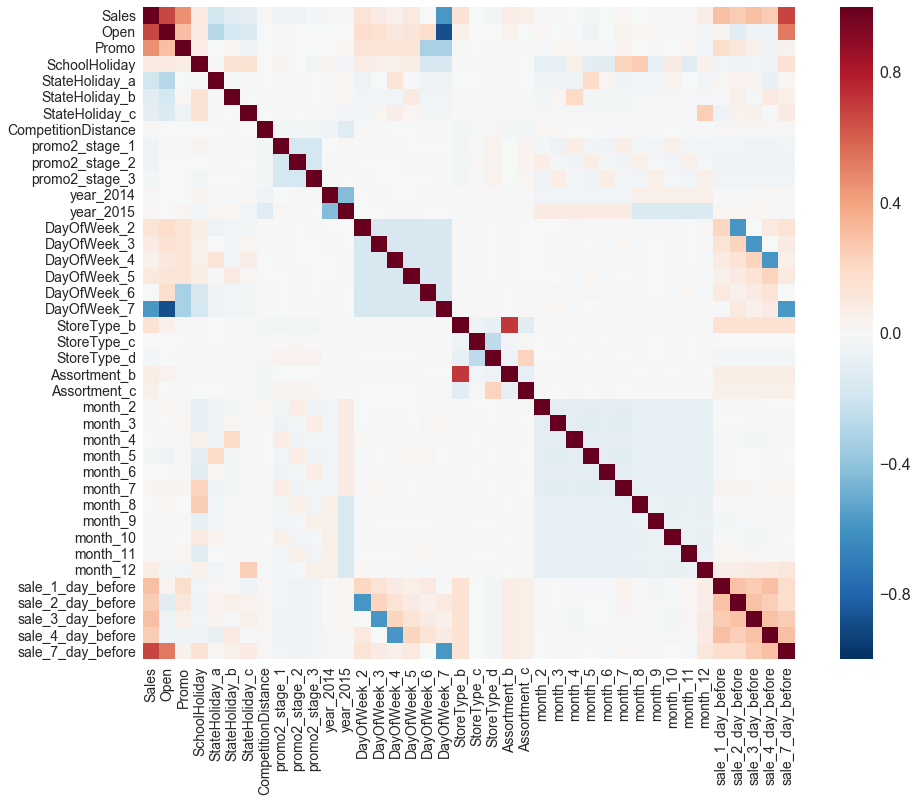

In [276]:
#plot correlations between features
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
rc={'axes.labelsize': 16, 'font.size': 16, 'legend.fontsize': 32.0, 'axes.titlesize': 24, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
sns.set(rc = rc)
sns.heatmap(master_df[important_columns].corr(),square=True);

In [278]:
#Visualize a simple example of XGBoost Trees
import random
shuffle_df = master_df[(master_df.Date <= traindate)].sample(frac=1).reset_index(drop=True)

In [279]:
shuffle_columns = ['CompetitionDistance', 'sale_1_day_before', 'sale_4_day_before', 'sale_7_day_before']

In [280]:
shuffle_X = shuffle_df[shuffle_columns]
shuffle_y = shuffle_df['Sales']

In [281]:
xgb_model_test = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, feval=rmspe_xg,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=91717,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [282]:
#random selected 50 records to train xgboost model
xgb_model_test.fit(shuffle_X[100:150], shuffle_y[100:150])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, feval=<function rmspe_xg at 0x11310ec80>,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=20, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=91717,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

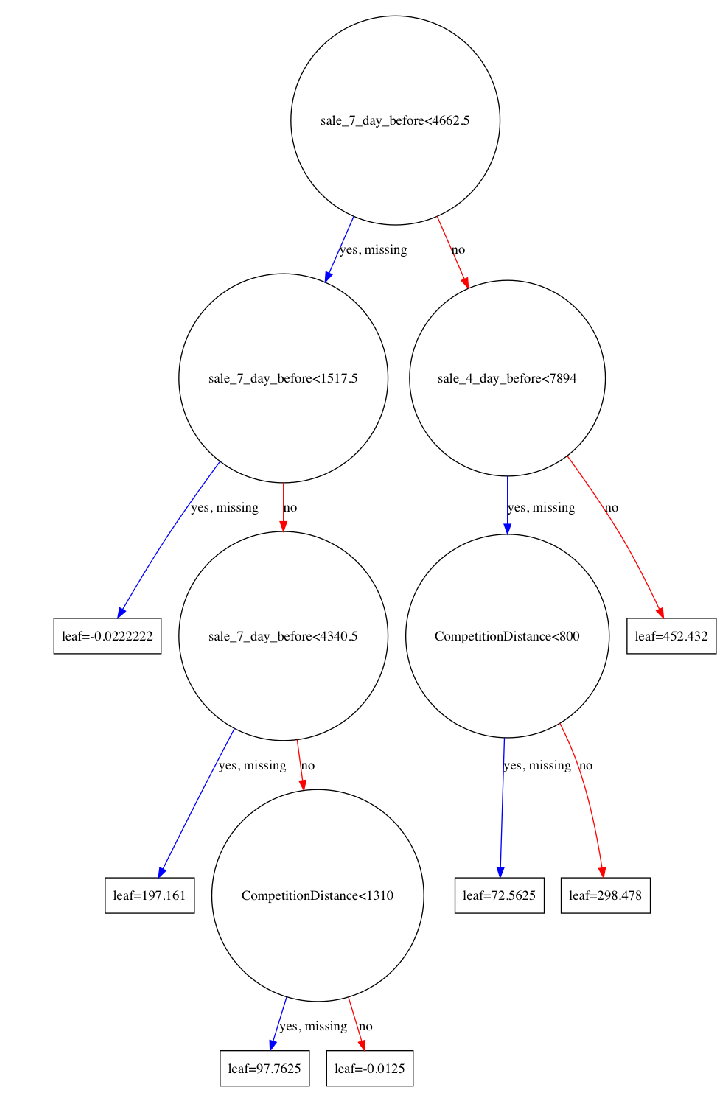

In [284]:
#plot one tree for xgboost
from xgboost import plot_tree
fig, ax = plt.subplots(1, 1, figsize=(12,20))
plot_tree(xgb_model_test, ax=ax);